In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
from scipy.signal import lfilter, butter, iirnotch
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq

In [ ]:
def get_glottal_wave(T, fs, duration):
  # T (sec) -  pitch period, fs (1/sec), duration (sec)
  Tp = int(0.4 * T * fs)
  Tn = int(0.16 * T * fs)
  Ts = int(T * fs)

  fp = [3 * (t / Tp) ** 2 - 2 * (t / Tp) ** 3 for t in range(Tp)]
  fn = [1 - ((t - Tp) / Tn) ** 2 for t in range(Tp, Tp + Tn)]
  f0 = [0 for t in range(Tp + Tn, Ts)]

  impulse = fp + fn + f0
  return impulse * int(duration / T)

In [ ]:
fs = 44100
f0 = 100

In [ ]:
def plot_spectrum(sig, fs, xlim=10000, log=False):
  freqs = rfftfreq(len(sig), 1/fs)
  spectrum = np.log(np.abs(rfft(sig))) if log else np.abs(rfft(sig))
  plt.plot(freqs, spectrum)
  plt.grid()
  plt.xlim(0, xlim)

In [ ]:
formants = {
    "a": [620,	1220,	2550,	3300,	4500],
    "a_m": [[620,	1220,	2550,	3300,	4500], 800],
    "o": [500, 800, 2500, 3200, 4300],
    "e": [550, 2000, 2600, 3450, 4700],
    "y": [450, 1400, 2300, 3400, 4500],
    "i": [300, 2200, 3000, 3700, 5000],
    "u": [300, 600, 2200, 3000, 4000],
    "w": [290, 610, 2150],
    "j": [260, 2070, 3020],
    "l": [310, 1050, 2880],
    "m": [[250, 1000, 2200], 800],
    "n": [[300, 1500, 3500], 1200],
    "ng": [[350, 1800, 2800], 1500],
    "r_voiced": [300, 750, 2100, 4000, 7200],
    "r_stop": [300, 750],
}

In [ ]:
bandwidths = {
    "a": [80, 100, 140, 200, 250],
    "a_m": [[80, 100, 140, 200, 250], 150],
    "o": [70, 90, 110, 180, 230],
    "e": [80, 100, 130, 200, 250],
    "y": [70, 110, 120, 200, 250],
    "i": [60, 110, 130, 220, 270],
    "u": [50, 80, 100, 170, 220],
    "w": [50, 80, 60],
    "j": [40, 250, 500],
    "l": [50, 100, 280],
    "m": [[50, 80, 120],150],
    "n": [[60, 90, 130], 200],
    "ng": [[350, 1800, 2800], 200],
    "r_voiced": [100, 200, 1000, 800, 800],
    "r_stop": [100, 200]
}

In [ ]:
stops = {
    "k": [[300, 1500], [250, 400], False, 120],
    "g": [[300, 1500], [250, 400], True, 120],
    "t": [[450, 2150, 3200, 8000], [600, 250, 400, 5000], False, 200],
    "d": [[450, 2150, 3200, 8000], [600, 250, 400, 5000], True, 200],
    "p": [[800], [700], False, 250],
    "b": [[800], [700], True, 250],
}

In [ ]:
consonants = {
    "s": [6000, 3000],
    "sh": [4000, 3000],
    "f": [1500, 1000]
}

In [ ]:
nasals = ("m", "n", "ng")
fricatives = ("s", "sh", "f")

In [ ]:
def one_band_filter(sig, F, BW, fs=fs):
  T = 1 / fs
  B = 2 * np.exp(-np.pi * BW * T) * np.cos(2* np.pi * F * T)
  C = -np.exp(-2 * np.pi * BW * T)
  A = 1 - B - C
  return lfilter([A], [1, -B, -C], sig)

In [ ]:
def generate_fricative(cons, duration, fs, make_envelope=True, is_voiced=False, noise_amplitude=0.3, F0=100):
  noise = np.random.normal(0, 1, int(duration * fs))

  nyqwist = 0.5 * fs
  low = (consonants[cons][0] - consonants[cons][1] / 2) / nyqwist
  high = (consonants[cons][0] + consonants[cons][1] / 2) / nyqwist
  b, a = butter(4, [low, high], btype="band")
  result = lfilter(b, a, noise)

  if is_voiced:
    t = np.linspace(0, duration, int(fs * duration))
    result *= noise_amplitude
    voiced_amplitude = 1 - noise_amplitude
    voiced = np.sin(2 * np.pi * F0 * t) * voiced_amplitude
    result += voiced

  if make_envelope:
    start = int(0.03 * fs)
    end = int(0.05 * fs)
    envelope = np.ones_like(result)
    envelope[:start] = np.linspace(0, 1, start)
    envelope[-end:] = np.linspace(1, 0, end)
    result = result * envelope

  result = result / np.max(np.abs(result))

  return result

In [ ]:
def get_sonorant_sound(phon, fs, f0, duration, nasal=False, left_decline=False, right_decline=False, left_dec_duration=0.02, right_dec_duration=0.02, intonation_decline=0):
  if not nasal:
    formants_ph = formants[phon]
    bandwidths_ph = bandwidths[phon]
  else:
    formants_ph = formants[phon][0]
    bandwidths_ph = bandwidths[phon][0]
    anti_f = formants[phon][1]
    anti_bw = bandwidths[phon][1]

  if intonation_decline == 0:
    source = get_glottal_wave(1/f0, fs, duration)
  else:
    source = []
    periods_num = int(duration * f0)
    i = 0
    while len(source) / fs < duration:
      new_freq = f0 * (1 + i * intonation_decline / periods_num)
      i += 1
      source.extend(get_glottal_wave(1 / new_freq, fs, 1 / new_freq))
      print("new_freq:", new_freq)

  res = source
  for f, bw in zip(formants_ph, bandwidths_ph):
    res = one_band_filter(res, f, bw, fs)

  if nasal:
    ba, aa = iirnotch(anti_f, anti_bw, fs=fs)
    res = lfilter(ba, aa, res)

  envelope = np.ones_like(res)

  if left_decline:
    start = int(left_dec_duration * fs)
    envelope[:start] = np.linspace(0, 1, start)

  if right_decline:
    end = int(right_dec_duration * fs)
    envelope[-end:] = np.linspace(1, 0, end)

  res *= envelope

  res /= np.max(np.abs(res))
  return res

In [ ]:
def make_morph_sound(first_phon, second_phon, number_of_periods, f0, fs):
  result = []

  is_first_nasal = first_phon in nasals
  is_second_nasal = second_phon in nasals

  is_first_fricative = first_phon in fricatives
  is_second_fricative = second_phon in fricatives

  if is_first_fricative or is_second_fricative:
    if is_first_fricative:
      envelope = np.linspace(1, 0, int(fs / f0 * number_of_periods))
      noise = generate_fricative(first_phon, number_of_periods/f0, fs, make_envelope=False) * envelope
      periodic = get_sonorant_sound(second_phon, fs, f0, number_of_periods/f0)
    else:
      envelope = np.linspace(0, 1, int(fs / f0 * number_of_periods))
      noise = generate_fricative(second_phon, number_of_periods/f0, fs, make_envelope=False) * envelope
      periodic = get_sonorant_sound(first_phon, fs, f0, number_of_periods/f0)

    min_len = min(len(noise), len(periodic))
    return noise[:min_len] + periodic[:min_len]

  if not is_first_nasal:
    formants_ph_1 = formants[first_phon]
    bandwidths_ph_1 = bandwidths[first_phon]
  else:
    formants_ph_1 = formants[first_phon][0]
    bandwidths_ph_1 = bandwidths[first_phon][0]
    anti_f_1 = formants[first_phon][1]
    anti_bw_1 = bandwidths[first_phon][1]

  if not is_second_nasal:
    formants_ph_2 = formants[second_phon]
    bandwidths_ph_2 = bandwidths[second_phon]
  else:
    formants_ph_2 = formants[second_phon][0]
    bandwidths_ph_2 = bandwidths[second_phon][0]
    anti_f_2 = formants[second_phon][1]
    anti_bw_2 = bandwidths[second_phon][1]

  morph_formants = []
  morph_bws = []

  for i in range(number_of_periods):
    morph_formants.append([])
    morph_bws.append([])
    for j in range(min(len(formants_ph_1), len(formants_ph_2))):
      morph_formants[-1].append(formants_ph_1[j] + (i + 1) * (formants_ph_2[j] - formants_ph_1[j]) / (number_of_periods + 1))
      morph_bws[-1].append(bandwidths_ph_1[j] + (i + 1) * (bandwidths_ph_2[j] - bandwidths_ph_1[j]) / (number_of_periods + 1))

  for i in range(number_of_periods):
    duration = 1 / f0
    source = get_glottal_wave(1/f0, fs, duration)
    res = source
    for f, bw in zip(morph_formants[i], morph_bws[i]):
      res = one_band_filter(res, f, bw, fs)

    if is_first_nasal:
      ba, aa = iirnotch(anti_f_1, anti_bw_1, fs=fs)
      res = lfilter(ba, aa, res)
    if is_second_nasal:
      ba, aa = iirnotch(anti_f_2, anti_bw_2, fs=fs)
      res = lfilter(ba, aa, res)

    result = np.concatenate((result, res))

  result /= np.max(np.abs(result))
  return result

In [ ]:
def get_stop_sound(phon, duration, fs):
  t = np.linspace(0, duration, int(fs*duration))

  source = np.random.normal(0, 0.1, len(t)) * np.exp(stops[phon][3] * (t - 0.2))

  if stops[phon][2]:
    voicing = np.sin(2*np.pi*120*t) * (t < 0.2) * 0.5
    source += voicing

  for f, bw, in zip(stops[phon][0], stops[phon][1]):
    source = one_band_filter(source, f, bw, fs)

  source /= np.max(np.abs(source))

  return source

In [ ]:

f0 = 120
f0_1 = 100

zdras = np.concatenate((
    0.1 * generate_fricative("s", 0.12, fs, F0=f0, make_envelope=False, is_voiced=True),
    0.1 * get_stop_sound("d", 0.05, fs),
    get_sonorant_sound("r_voiced", fs, f0, 0.03, left_decline=True, left_dec_duration=0.015, right_decline=True, right_dec_duration=0.015),
    0.4 * get_sonorant_sound("r_stop", fs, f0, 0.01),
    get_sonorant_sound("r_voiced", fs, f0, 0.03, left_decline=True, left_dec_duration=0.015),
    0.4 * get_sonorant_sound("r_stop", fs, f0, 0.01),
    get_sonorant_sound("r_voiced", fs, f0, 0.03, left_decline=True, left_dec_duration=0.015),
    make_morph_sound("r_voiced", "a", 5, f0, fs),
    get_sonorant_sound("a", fs, f0, 0.1, intonation_decline=-0.15),
    0.3 * make_morph_sound("a", "s", 5, f0, fs),
    0.3 * generate_fricative("s", 0.1, fs, make_envelope=False),
    0.1 * get_stop_sound("t", 0.1, fs),
    0.05 * generate_fricative("f", 0.03, fs, make_envelope=False, is_voiced=True),
    0.2 * get_sonorant_sound("w", fs, f0_1, 0.02),
    0.2 * make_morph_sound("w", "u", 5, f0_1, fs),
    0.2 * get_sonorant_sound("u", fs, f0_1, 0.04),
    0.2 * make_morph_sound("u", "i", 5, f0_1, fs),
    0.2 * get_sonorant_sound("i", fs, f0_1, 0.05),
    0.1 * get_stop_sound("t", 0.02, fs),
    0.1 * generate_fricative("s", 0.03, fs, make_envelope=False),
    0.2 * make_morph_sound("s", "i", 5, f0_1, fs),
    0.2 * get_sonorant_sound("i", fs, f0_1, 0.1),
))

new_freq: 120.0
new_freq: 118.5
new_freq: 117.0
new_freq: 115.5
new_freq: 114.0
new_freq: 112.5
new_freq: 111.0
new_freq: 109.5
new_freq: 108.0
new_freq: 106.5
new_freq: 105.0
new_freq: 103.5


In [ ]:
Audio(zdras, rate=fs)

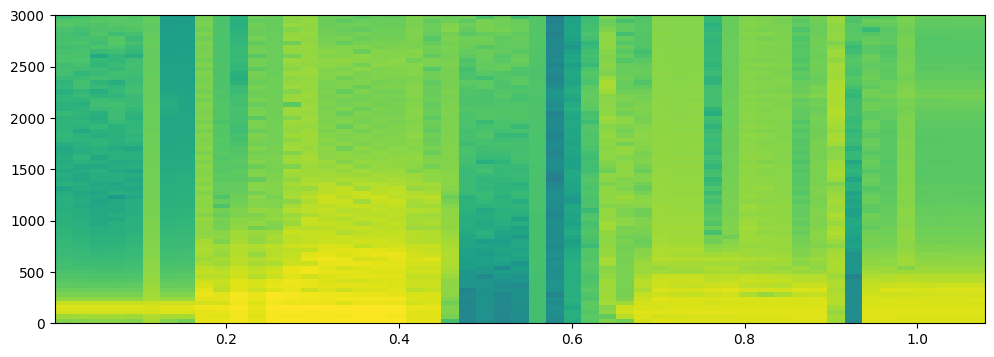

In [ ]:
plt.figure(figsize=(12, 4))
plt.specgram(zdras, Fs=fs, NFFT=1024)
plt.ylim(0, 3000)
plt.show()

In [ ]:
sasha = np.concatenate((
    generate_fricative('s', 0.2, fs),
    make_morph_sound('s', 'a', 5, f0, fs),
    get_sonorant_sound('a', fs, f0, 0.3),
    make_morph_sound('a', 'sh', 5, f0, fs),
    generate_fricative('sh', 0.2, fs),
    make_morph_sound('sh', 'a', 5, f0, fs),
    get_sonorant_sound('a', fs, f0, 0.2),
))

In [ ]:
Audio(sasha, rate=fs)

In [ ]:
def make_r_sound(left_vowel, right_vowel, number_of_flaps, f0, fs):
  formants_r_left = [300, 750, 2100, 4000, 7200]
  bandwidths_r_left = [100, 200, 1000, 800, 800]

  formants_r_right = [300, 750, 2100, 4000, 7200]
  bandwidths_r_right = [100, 200, 1000, 800, 800]

  formants_r_left[0] = formants[left_vowel][0]
  bandwidths_r_left[0] = bandwidths[left_vowel][0]

  formants_r_right[0] = formants[right_vowel][0]
  bandwidths_r_right[0] = bandwidths[right_vowel][0]

  res = []
  source = get_glottal_wave(1/f0, fs, 0.02)
  source_stop = get_glottal_wave(1/f0, fs, 0.01)

  for i in range(number_of_flaps):
    for f, bw in zip(formants_r_left, bandwidths_r_left):
      res_filt = one_band_filter(source, f, bw, fs)
    res = np.concatenate((res, res_filt))
    r_stop = one_band_filter(source, formants_r_left[0], bandwidths_r_left[0], fs)
    res = np.concatenate((res, r_stop))

    for f, bw in zip(formants_r_right, bandwidths_r_right):
      res_filt = one_band_filter(source, f, bw, fs)
    res = np.concatenate((res, res_filt))
    r_stop = one_band_filter(source, formants_r_right[0], bandwidths_r_right[0], fs)
    res = np.concatenate((res, r_stop))

  return res

In [ ]:
f0_1 = 125
f0_2 = 115

juri_trifanaf = np.concatenate((
    0.5 * get_sonorant_sound('j', fs, f0, 0.15, left_decline=True, left_dec_duration=0.14),
    make_morph_sound('j', 'u', 5, f0, fs),
    get_sonorant_sound('u', fs, f0, 0.02, intonation_decline=0.05),
    make_morph_sound('u', 'r_voiced', 10, f0_1, fs),
    get_sonorant_sound("r_voiced", fs, f0_1, 0.02),
    0.4 * get_sonorant_sound("r_stop", fs, f0_1, 0.01),
    get_sonorant_sound("r_voiced", fs, f0_1, 0.02),
    make_morph_sound('r_voiced', 'i', 5, f0_1, fs),
    get_sonorant_sound('i', fs, f0_1, 0.2, right_decline=True, right_dec_duration=0.1),
    get_stop_sound('t', 0.14, fs),
    get_sonorant_sound("r_voiced", fs, f0_2, 0.02),
    0.4 * get_sonorant_sound("r_stop", fs, f0_2, 0.01),
    get_sonorant_sound("r_voiced", fs, f0_2, 0.02),
    make_morph_sound('r_voiced', 'i', 5, f0_2, fs),
    get_sonorant_sound('i', fs, f0_2, 0.1, intonation_decline=-0.1),
    make_morph_sound('i', 'f', 2, f0, fs),
    0.1 * generate_fricative("f", 0.1, fs, make_envelope=False),
    0.7 * make_morph_sound('f', 'a', 2, f0, fs),
    0.7 * get_sonorant_sound('a', fs, f0, 0.03),
    0.7 * make_morph_sound('a', 'n', 5, f0, fs),
    0.7 * get_sonorant_sound('n', fs, f0, 0.05, nasal=True),
    0.7 * make_morph_sound('n', 'a', 5, f0, fs),
    0.7 * get_sonorant_sound('a', fs, f0, 0.07),
    0.7 * make_morph_sound('a', 'f', 2, f0, fs),
    0.1 * generate_fricative("f", 0.2, fs, make_envelope=False),
))

new_freq: 120.0
new_freq: 122.99999999999999
new_freq: 126.0
new_freq: 115.0
new_freq: 113.95454545454547
new_freq: 112.9090909090909
new_freq: 111.86363636363637
new_freq: 110.81818181818181
new_freq: 109.77272727272728
new_freq: 108.72727272727272
new_freq: 107.68181818181819
new_freq: 106.63636363636364
new_freq: 105.5909090909091
new_freq: 104.54545454545455


In [ ]:
f0_1 = 125
f0_2 = 115

juri_trifanaf_2 = np.concatenate((
    0.5 * get_sonorant_sound('j', fs, f0, 0.15, left_decline=True, left_dec_duration=0.14),
    make_morph_sound('j', 'u', 5, f0, fs),
    get_sonorant_sound('u', fs, f0, 0.02, intonation_decline=0.05),
    make_r_sound('u', 'i', 1, f0_1, fs),
    get_sonorant_sound('i', fs, f0_1, 0.2, right_decline=True, right_dec_duration=0.1),
    get_stop_sound('t', 0.14, fs),
    make_r_sound('i', 'a', 1, f0_1, fs),
    get_sonorant_sound('i', fs, f0_2, 0.1, intonation_decline=-0.1),
    make_morph_sound('i', 'f', 2, f0, fs),
    0.1 * generate_fricative("f", 0.1, fs, make_envelope=False),
    0.7 * make_morph_sound('f', 'a', 2, f0, fs),
    0.7 * get_sonorant_sound('a', fs, f0, 0.03),
    0.7 * make_morph_sound('a', 'n', 5, f0, fs),
    0.7 * get_sonorant_sound('n', fs, f0, 0.05, nasal=True),
    0.7 * make_morph_sound('n', 'a', 5, f0, fs),
    0.7 * get_sonorant_sound('a', fs, f0, 0.07),
    0.7 * make_morph_sound('a', 'f', 2, f0, fs),
    0.1 * generate_fricative("f", 0.2, fs, make_envelope=False),
))

new_freq: 120.0
new_freq: 122.99999999999999
new_freq: 126.0
new_freq: 115.0
new_freq: 113.95454545454547
new_freq: 112.9090909090909
new_freq: 111.86363636363637
new_freq: 110.81818181818181
new_freq: 109.77272727272728
new_freq: 108.72727272727272
new_freq: 107.68181818181819
new_freq: 106.63636363636364
new_freq: 105.5909090909091
new_freq: 104.54545454545455


In [ ]:
Audio(juri_trifanaf, rate=fs)

In [ ]:
Audio(juri_trifanaf_2, rate=fs)

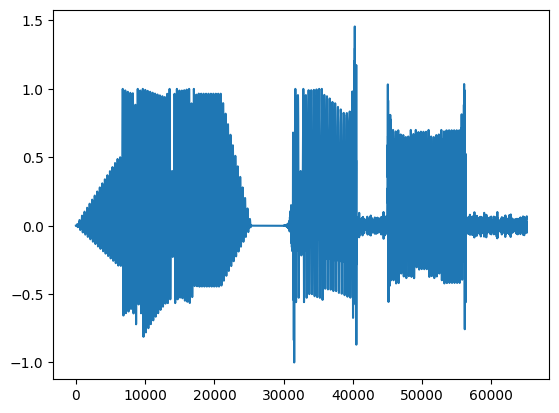

In [ ]:
plt.plot(juri_trifanaf)

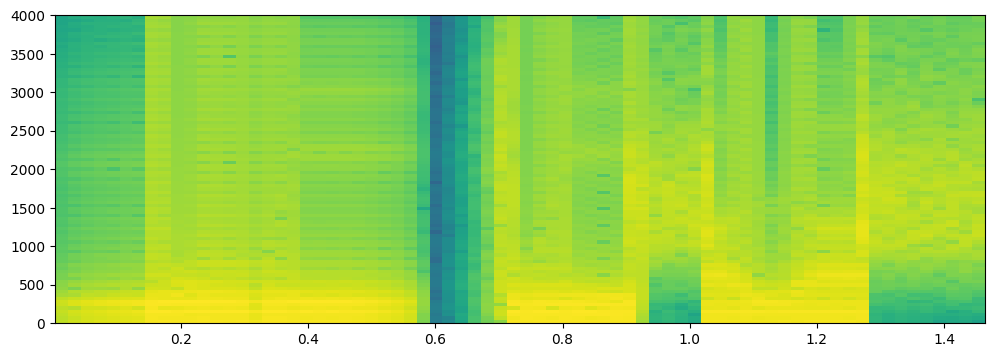

In [ ]:
plt.figure(figsize=(12, 4))
plt.specgram(juri_trifanaf, Fs=fs, NFFT=1024)
plt.ylim(0, 4000)
plt.show()

In [ ]:
wavfile.write("trifanaf.wav", fs, juri_trifanaf)